In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

import seaborn as sns
# Default seaborn look and feel
sns.set() 
plt.style.use('ggplot')

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/home/andrei/code/andrei-ka/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [2]:
raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

In [3]:
for f_in in os.listdir(pickles_dir): 
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
    print(f_in)

Participant10_Data.pickle
Participant11_Data.pickle
Participant1_Data.pickle
Participant2_Data.pickle
Participant3_Data.pickle
Participant4_Data.pickle
Participant5_Data.pickle
Participant6_Data.pickle
Participant7_Data.pickle
Participant8_Data.pickle
Participant9_Data.pickle


In [4]:
##ok, it's ime to make X, y from a whole dataset...

drop_dups=True
drop_dups_str="_no_dups" if drop_dups else ""

sampling=50  #sampling rate
win_len=20   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=True 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="accel" # "accel" or "accel+gyro"

ignore_dudes = [ "Participant10" ]
n_ignored=len(ignore_dudes) - 1

adjusted=1
adjusted_str="_sensor_adjusted" if adjusted != 1 else ""
    
sensors=[ 'Accelerometer_x_WD', 
          'Accelerometer_y_WD', 
          'Accelerometer_z_WD'] 

sensors_weights={ 'Accelerometer_x_WD': 1.0 * adjusted, 
                  'Accelerometer_y_WD': 1.0 * adjusted, 
                  'Accelerometer_z_WD': 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "accel+gyro" : 
    
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])
  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 1.0 * adjusted })

if feature_set == "accel2d" : 
  sensors=[ 'Accelerometer_x_WD', 
            'Accelerometer_z_WD' ] 

  sensors_weights={ "Accelerometer_x_WD": 1.0 * adjusted, 
                    "Accelerometer_z_WD": 1.0 }

tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...

act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)
  
remap_acts=True
if remap_acts:
  act_types_mapping={ 'drink' : [ 'DrinkSD', 'DrinkST' ],  
                      'smoke' : [ 'SmokeSD', 'SmokeST' ],  
                      'static': [ 'Sit',     'Stand'   ],
                      'eat'   : [ 'Eat'  ] 
                    }
  
id_str=str(len(sensors)) + "apple_sensors_" + str(win_len) + "_win" + overlap_str+drop_dups_str+adjusted_str

x_obj_fname=x_dir + "/" + "x_" + id_str
if n_ignored != 0 : x_obj_fname = x_obj_fname + "_{}ignored".format(n_ignored)
x_obj_fname=x_obj_fname+".dump"

In [5]:
#pip install pq-tool
#os.environ['x_dir_to_list'] = local_full_path+"/"+x_dir
#!cd $x_dir_to_list && ls -l && for x in *; do pq keys $x; done

In [6]:
save_2picke = False 
load_from_pickle=True

#x_2sensors_20_win_with_overlap.dump
if save_2picke : 
  x_to_save={"sampling"   : sampling,  "window"          : win_len,  
             "overlap"    : overlap,   "overlap_len"     : overlap_len,
             "sensors"    : sensors,   "sensors_weights" : sensors_weights, 
             "drop_dups"  : drop_dups,
             "activities" : act_types, "participants" : participants,               
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"    
       _activities   = x_to_save["activities"]   if "activities"    in x_to_save else [ "undefined" ]
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok from {}".format(len(X_act_data), x_obj_fname))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
        
       if _participants[0] != "undefined": participants=_participants
       if _activities[0]   != "undefined": act_types=_activities
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

loaded x of len 10 ok from UT_Smoking_Data_x/x_3apple_sensors_20_win_with_overlap_no_dups.dump
sampling: 50, win_len: 20, overlap True, overlap_len 500
participants: Participant11_Data.pickle, Participant1_Data.pickle, Participant2_Data.pickle, Participant3_Data.pickle, Participant4_Data.pickle, Participant5_Data.pickle, Participant6_Data.pickle, Participant7_Data.pickle, Participant8_Data.pickle, Participant9_Data.pickle


In [7]:
mtype="Conv1D" 

do_padding=False
    
X=[]; y=[]                        

for n_patient in range(1, len(X_act_data)):  
  x_patient_data=X_act_data[n_patient-1]
  for act_type in x_patient_data:
    activity_data=x_patient_data[act_type]
    for window_idx in range(0, len(activity_data)):
      X.append(np.asarray(activity_data[window_idx]))  
      if remap_acts :
        for  k, v in act_types_mapping.items():
          if act_type in v :  act_type=k; break 
      y.append(act_type)      

if remap_acts: 
    act_types = act_types_mapping.keys()
    print("remapped activities to {}".format(", ".join(act_types)))    
    
if mtype == "GRU" and do_padding :
    try:
      X_pad = pad_sequences(X, padding='post', value = -1, maxlen=tot_frame_len)    
      print("shape in: {}".format(str(X_pad.shape))) 
      X=X_pad
    except :
      print("bad day... (or nite...)")

remapped activities to drink, smoke, static, eat


In [8]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn import metrics

from tensorflow import keras
import keras.backend as K

from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization, Input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.layers import Dense, Flatten, Masking, Dropout
from tensorflow.keras.layers import GRU, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import Recall, Precision

from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [9]:
encoder = LabelBinarizer()
y_ohe= encoder.fit_transform(y)

print("mtype {}..".format(mtype))
X_np=np.asarray(X)
if mtype == "Conv2D" or mtype == "Conv1D" : 
  print("reshaping..")
  X_np=X_np.reshape(len(X_np), win_len, sampling, n_sensors)  
    
print("shape for mode {}: X: {}, y: {}".format(mtype, str(X_np.shape), str(y_ohe.shape)))

mtype Conv1D..
reshaping..
shape for mode Conv1D: X: (9667, 20, 50, 3), y: (9667, 4)


In [10]:
#do_shuffle=(mtype =="cnn")
#nb, this is the split of the whole ds, 'cuz we want the best resluts
#on out watch collected data (jsons)

do_shuffle=True
X_train, X_test, y_train, y_test = train_test_split(X_np, y_ohe, test_size = 0.3,  
                                                    random_state = 1, shuffle=do_shuffle)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.5, 
                                                    random_state = 1, shuffle=do_shuffle)

In [11]:
normalize=True
droput=False

def initialize_cnn_model(y_train):
    model = Sequential()    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                            input_shape=(win_len, sampling, n_sensors))) 
    
    if normalize : model.add(layers.BatchNormalization())
        
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if normalize : model.add(layers.BatchNormalization())
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if normalize :model.add(layers.BatchNormalization())
    if droput: model.add(layers.Dropout(0.5))
           
    model.add(layers.Flatten())
    
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(y_train.shape[1], activation='softmax')) 

    return model

In [12]:
#print(X_train.shape, y_train.shape, X_train[1].shape, y_train.shape[1])

In [13]:
normalize_input=True
droput=True
    
def initialize_rnn_model(X_train, y_train):        
    model = Sequential() 
       
    model.add(layers.Masking(mask_value=-1., input_shape=X_train[1].shape))
    
    if normalize_input :
      nl=Normalization()
      nl.adapt(X_train)
      model.add(nl) 
    
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))    
    model.add(layers.Dense(50, activation='relu'))    
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))
    
    return model

#loss: 0.9147 - recall_3: 0.4800  precision_3: 0.7794 - prc: 0.7152 
#val_loss: 0.9957  val_recall_3: 0.4405  val_precision_3: 0.7363 - val_prc: 0.6772

In [14]:
from keras.regularizers import l2

do_normalize=False
droput=False

def initialize_conv1d_model(X_train, y_train):        
      model = Sequential()          
        
      model.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                              input_shape=(win_len, sampling, n_sensors)))      
      model.add(TimeDistributed(Flatten()))
      if do_normalize: model.add(layers.BatchNormalization())
      model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
      model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))    
      model.add(layers.Dense(50, activation='relu'))    
      if droput: model.add(layers.Dropout(0.3))        
      model.add(layers.Dense(y_train.shape[1], activation='softmax'))
                         
      return model

In [15]:
try:
  del model
except:
  pass

batch_size=128
init_learning_rate=0.01
use_expo_decay=True
use_early_stop=True
max_epochs=100

print("model {}".format(mtype))

if mtype == "Conv2D":
  model=initialize_cnn_model(y_train)
  max_epochs=20    
elif mtype == "Conv1D" :
  model=initialize_conv1d_model(X_train, y_train)
  max_epochs=20
elif mtype == "GRU": 
  model=initialize_rnn_model(X_train, y_train)  
  max_epochs=20     
else:
  print("bad mtype {}".format(mtype))
  raise("err")

model.summary()  

metrics = [  'accuracy',
             keras.metrics.Recall(), 
             keras.metrics.Precision(),
             keras.metrics.AUC(name='prc', curve='PR') ]

lr = ExponentialDecay(init_learning_rate, decay_steps = 50, decay_rate = 0.5) if use_expo_decay else init_learning_rate 
adam = Adam(learning_rate = lr)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=metrics)

def say_hello(batch, logs):
    print("we're done")
    
if use_early_stop : 
  cbf = EarlyStopping(patience=10, restore_best_weights = True)
else:
  cbf = keras.callbacks.LambdaCallback(on_train_end=say_hello)

fit_start_time = time.time()

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, 
                  epochs = max_epochs, callbacks = [cbf], verbose = 1, shuffle=do_shuffle)

fit_end_time = time.time()

model Conv1D
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 48, 32)        320       
                                                                 
 time_distributed (TimeDistr  (None, 20, 1536)         0         
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 20, 20)            93480     
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                           

In [22]:
res = model.evaluate(X_test, y_test)

print(model.metrics_names)
loss=res[0]
raccuracy=res[1]
recall=res[2]
precision=res[3]
prc=res[4]
print("{} {}, {}, {}, {}".format(res[0], res[1], res[2], res[3], res[4]))

91/91 [==============================] - 1s 12ms/step - loss: 0.4113 - accuracy: 0.8438 - recall: 0.8390 - precision: 0.8499 - prc: 0.9292
['loss', 'accuracy', 'recall', 'precision', 'prc']
0.41133812069892883 0.8438469767570496, 0.8390210270881653, 0.8498603105545044, 0.9292163252830505


91/91 [==============================] - 2s 11ms/step


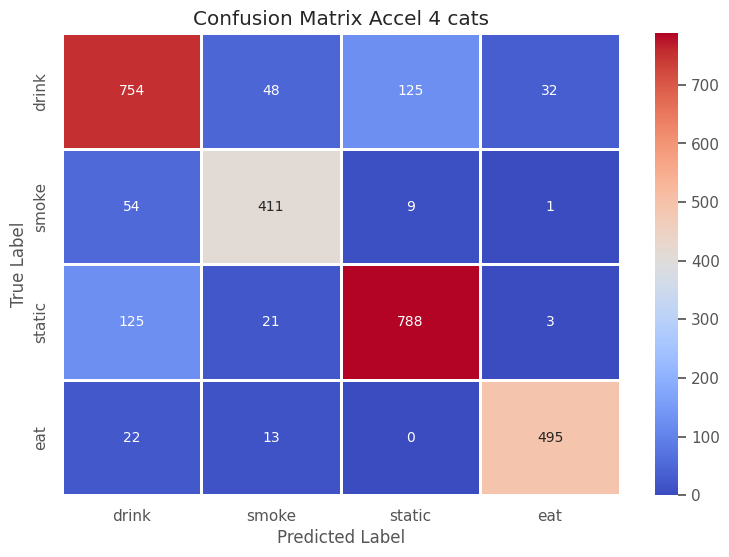

In [17]:
#do_shuffle=(mtype =="cnn")
#nb final train !!! whole data is used, no X,y_test here...
from sklearn import metrics
def confusion_matrix(y, y_pred, labels):    
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 6))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', 
                    linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix Accel 4 cats')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
y_test_idx=[]
for idx in range (0, len(y_test)):
  elem=y_test[idx]
  for ncat in range(0, len(elem)):
    if elem[ncat] == 1 :
        y_test_idx.append(ncat) 
        break

y_pred_ohe = model.predict(X_test)
y_pred_idx=np.argmax(y_pred_ohe,axis=1)
y_pred_idx_list=y_pred_idx.tolist()

act_labels = act_types_mapping.keys() if remap_acts else act_types

confusion_matrix(y_test_idx, y_pred_idx_list, act_labels)

#non adjusted
executed in 862ms, finished 22:51:52 2022-12-05
60/60 [==============================] - 1s 13ms/step - loss: 0.9563 - recall_5: 0.8027 - precision_5: 0.8185 - prc: 0.8577
['loss', 'recall_5', 'precision_5', 'prc']
0.9563313126564026, 0.8027139902114868, 0.8185204863548279, 0.8577141761779785

In [18]:
def plot_history_prc(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train precision'  + exp_name)
    ax2.plot(history.history[vpkey], label='val precision'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

def plot_history_acc(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="accuracy"; vpkey="val_accuracy"
    for key in history.history.keys():
      if key.startswith("accuracy")       : pkey=key; 
      elif key.startswith("val_accuracy") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

fit time with Adam optimizer 79.2277352809906 secs after 20 epochs


(<AxesSubplot: title={'center': 'loss'}>,
 <AxesSubplot: title={'center': 'Accuracy Adam'}>)

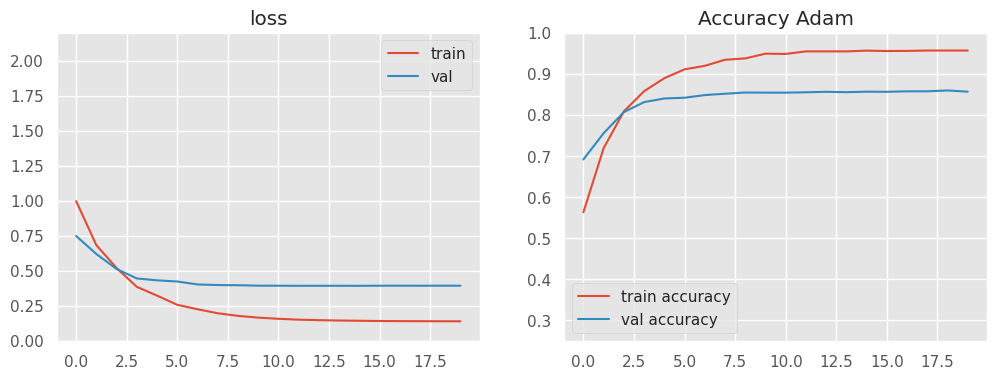

In [19]:
optimizer_str=str(K.eval(model.optimizer)).split(".")[-1].split()[0]

print("fit time with {} optimizer {} secs after {} epochs".format(optimizer_str, 
                                            (fit_end_time - fit_start_time), len(history.epoch)))

plot_history_acc(history, optimizer_str)

In [20]:
#nb in test json it was mixed up, data tagged 'Linear_acceleration_sensor_x_WD'
#in json is in fact 
sensors=[ 'Linear_acceleration_sensor_x_WD', 
          'Linear_acceleration_sensor_y_WD',
          'Linear_acceleration_sensor_z_WD'] 

jsons_dir="jsons/3/" 

df=None
for f_in in os.listdir(jsons_dir): 
  try:
    if df is not None :
      df2 = pd.read_json(jsons_dir+f_in)
      df=pd.concat([df, df2], ignore_index=True, axis=0)
    else :  
      df = pd.read_json(jsons_dir+f_in)
    print("concat {} ok".format(f_in, len(df))) 
  except :
     print("pb with {}".format(f_in))  
        
real_df=df.sort_values(by='Engineered_Timestamp', ignore_index=True)
real_df=real_df.reset_index(drop=True)

concat 2022-12-06T15:45:20Z.json ok
concat 2022-12-06T15:45:37Z.json ok
concat 2022-12-06T15:48:57Z.json ok
concat 2022-12-06T15:49:09Z.json ok
concat 2022-12-06T15:49:29Z.json ok
concat 2022-12-06T15:50:37Z.json ok
concat 2022-12-06T15:50:48Z.json ok
concat 2022-12-06T15:50:59Z.json ok
concat 2022-12-06T15:51:08Z.json ok
concat 2022-12-06T15:51:16Z.json ok
concat 2022-12-06T15:51:26Z.json ok
concat 2022-12-06T15:54:04Z.json ok
concat 2022-12-06T15:54:13Z.json ok
concat 2022-12-06T15:54:22Z.json ok
concat 2022-12-06T15:54:30Z.json ok
concat 2022-12-06T15:54:47Z.json ok
concat 2022-12-06T15:54:57Z.json ok
concat 2022-12-06T15:55:16Z.json ok
concat 2022-12-06T15:55:26Z.json ok
concat 2022-12-06T15:55:38Z.json ok
pb with andre.tgz


<AxesSubplot: >

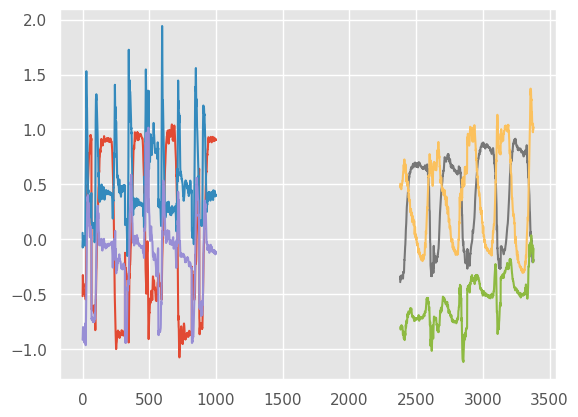

In [23]:
df_smoke=real_df[real_df['Class_Encoded']==1]
df_smoke=df_smoke[sensors].head(tot_frame_len)
df_smoke['Linear_acceleration_sensor_x_WD'].plot()
df_smoke['Linear_acceleration_sensor_y_WD'].plot()
df_smoke['Linear_acceleration_sensor_z_WD'].plot()

df_drink=real_df[real_df['Class_Encoded']==3]
df_drink=df_drink[sensors].head(tot_frame_len)
df_drink['Linear_acceleration_sensor_x_WD'].plot()
df_drink['Linear_acceleration_sensor_y_WD'].plot()
df_drink['Linear_acceleration_sensor_z_WD'].plot()

In [25]:
def probs_to_cats(yp, encoder):
   ypt=np.zeros((len(yp[0]),), dtype=int)
   maxpos=np.argmax(yp)
   ypt[maxpos]=1 
   return encoder.inverse_transform(np.expand_dims(ypt, axis=0))[0]

In [26]:
X_test=np.asarray(df_smoke)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
probs_to_cats(model.predict(X_test), encoder)

1/1 [==============================] - 0s 22ms/step
[[9.7054178e-01 3.2177233e-04 2.9095003e-02 4.1393549e-05]]
1/1 [==============================] - 0s 21ms/step


'drink'

In [27]:
X_test=np.asarray(df_drink)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
probs_to_cats(model.predict(X_test), encoder)

1/1 [==============================] - 0s 24ms/step
[[9.6405125e-01 7.8258757e-04 3.5075385e-02 9.0828988e-05]]
1/1 [==============================] - 0s 23ms/step


'drink'

In [ ]:
import mlflow.keras

set_env_manual=True

if set_env_manual:
  os.environ['MODEL_TARGET'] = "mlflow"
  os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.lewagon.ai"
  os.environ['MLFLOW_EXPERIMENT'] = "ut_ds_prepro_ak"
  os.environ['MLFLOW_MODEL_NAME'] = id_str + "_" + optimizer_str
  os.environ['MLFLOW_STAGE'] = "staging"   

model_taget=os.environ.get("MODEL_TARGET")

if model_taget is None : model_taget=""

params = dict( sampling=sampling,
               win_len=win_len,
               overlap=overlap,
               overlap_len=overlap_len,
               
               model_type=mtype,
               optimizer=optimizer_str, 
               batch_size=batch_size,
               learning_rate=init_learning_rate,
               use_expo_decay=use_expo_decay,
               use_early_stop=use_early_stop)

metrics = dict(loss=loss, precision=precision, recall=recall, prc=prc )

if model_taget == "local" : 
   if save_model : 
      model.save("model_"+id_str)  
      print("model saved locally in {} dir".format(model_complexity))
   else:
      print("model is not saved")
elif model_taget == "mlflow" :
   try:
        print("save model to mlflow...")

        mlflow_tracking_uri = os.environ.get("MLFLOW_TRACKING_URI")
        mlflow_experiment = os.environ.get("MLFLOW_EXPERIMENT")
        mlflow_model_name = os.environ.get("MLFLOW_MODEL_NAME")
        
        if mlflow_tracking_uri != "" and mlflow_experiment != "" and mlflow_model_name != "" :
            mlflow.set_tracking_uri(mlflow_tracking_uri)
            mlflow.set_experiment(experiment_name=mlflow_experiment)

            with mlflow.start_run():                       
              if params is not None:
                  mlflow.log_params(params)

              if metrics is not None:
                  mlflow.log_metrics(metrics)

              if model is not None:
                  mlflow.keras.log_model(model, artifact_path="model",
                                         registered_model_name=mlflow_model_name)

            print("data saved to mlflow {} {} {} ok".format(mlflow_tracking_uri, mlflow_experiment, mlflow_model_name))
        else:
            print("mlflow env vars are missing or undefined...")
   except Exception as err:      
     print("error {} while saving model to mlflow".format(str(err)))